In [2]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import utils.ssvep_analysis as sa
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

In [3]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    match = re.search(r'Subject:\s*(\S+)', content)
    subject = str(match.group(1))
    match = re.search(r'Series:\s*(\S+)', content)
    series = str(match.group(1))
    marker = df.to_numpy()[:, 0]
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, marker, severity, subject, series

def preprocess_data(eeg_data, marker):
    eeg_data = sa.remove_artefacts(eeg_data)
    eeg_data = sa.apply_ransac_detrending(eeg_data,)
    eeg_data = sa.apply_bandpass_filter(eeg_data, lowcut=14, highcut=35)
    eeg_data = sa.apply_notch_filter(eeg_data)
    eeg_data, _ = sa.compute_reduced_signal(eeg_data)

    start = np.argwhere(marker != 'grey')[0][0]
    end = np.argwhere(marker != 'grey')[-1][0]
    eeg_data = eeg_data[start:end]
    return eeg_data

def build_dataset(directory_list):
    X = []
    y = []
    groups = []
    severities = []
    max_len = 0
    for directory in directory_list:
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, marker, severity, subject, series = read_data(file_path)
            if series != 'multicolor-deuteranomaly-series' or eeg_data.shape[0] < 7000:
                continue
            eeg_data = preprocess_data(eeg_data, marker)
            X.append(eeg_data)
            y.append(0 if severity == 0 else 1)
            groups.append(subject)
            severities.append(severity)
            max_len = max(max_len, eeg_data.shape[0])
    return X, np.array(y), np.array(groups), np.array(severities), max_len

def zero_pad(X, max_len):
    for i in range(len(X)):
        if len(X[i]) < max_len:
            X[i] = np.concatenate((X[i], np.zeros(max_len - len(X[i]))))
        else:
            X[i] = X[i][:max_len]
    return np.array(X)

directory_list = ['2024-01-12', '2024-01-19', '2024-01-22', '2024-03-04-Gurke', '2024-03-04-Schroedi', '2024-03-08-Schwein', '2024-03-14-Daddy', '2024-03-08-Happy', '2024-03-23-Maracuja', '2024-03-25-Lillifee', '2024-03-07-Tomate', '2024-03-07-Badewanne']

X, y, groups, severities, max_len = build_dataset(directory_list)
X = zero_pad(X, max_len)
print(X.shape)

(340, 7773)


In [4]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.5, random_state=1)

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1)),
    ('svm', SVC(probability=True, random_state=1))
])

grid = {
    'wavelet_transformer__w_list': [[20, 50, 1000]],
    'wavelet_transformer__n_samples': [100],
    'wavelet_transformer__n_frequencies': [100],
    'pca__n_components': [8],
    'svm__C': [10],
    'svm__gamma': ['scale'],
    'svm__kernel': ['linear']# , 'rbf', generalized_cone_kernel]
}

grid_search = GridSearchCV(pipeline, grid, cv=LeaveOneGroupOut(), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train, groups=groups_train)
params = grid_search.best_params_
print('Best Params:', params)
print(f'Best Accuracy: {grid_search.best_score_:.2%}')

Best Params: {'pca__n_components': 8, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'wavelet_transformer__n_frequencies': 100, 'wavelet_transformer__n_samples': 100, 'wavelet_transformer__w_list': [20, 50, 1000]}
Best Accuracy: 90.00%


In [5]:
pipeline.set_params(**params)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

Accuracy: 86.47%
AUC ROC: 0.95


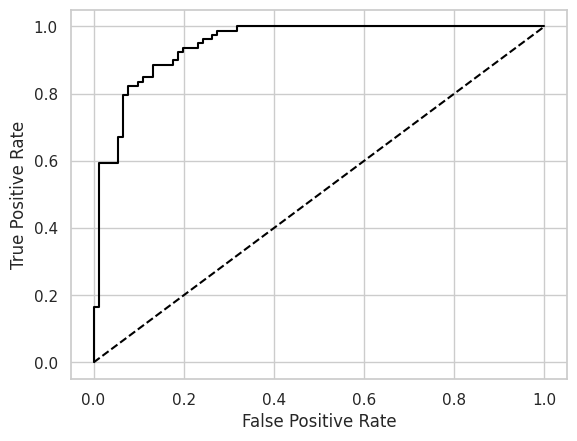

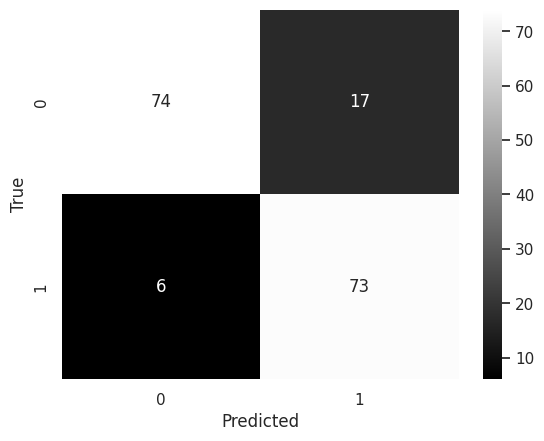

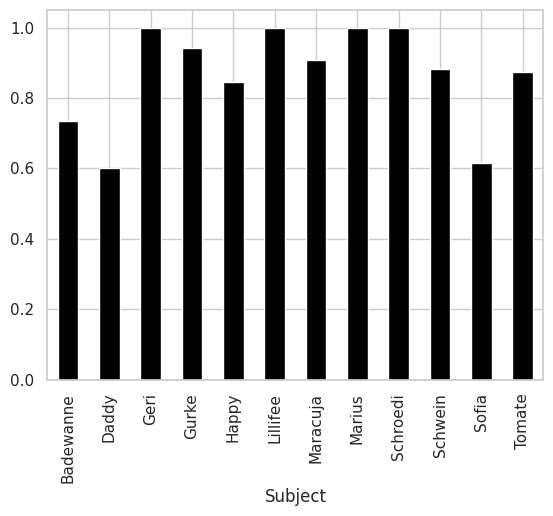

In [6]:
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

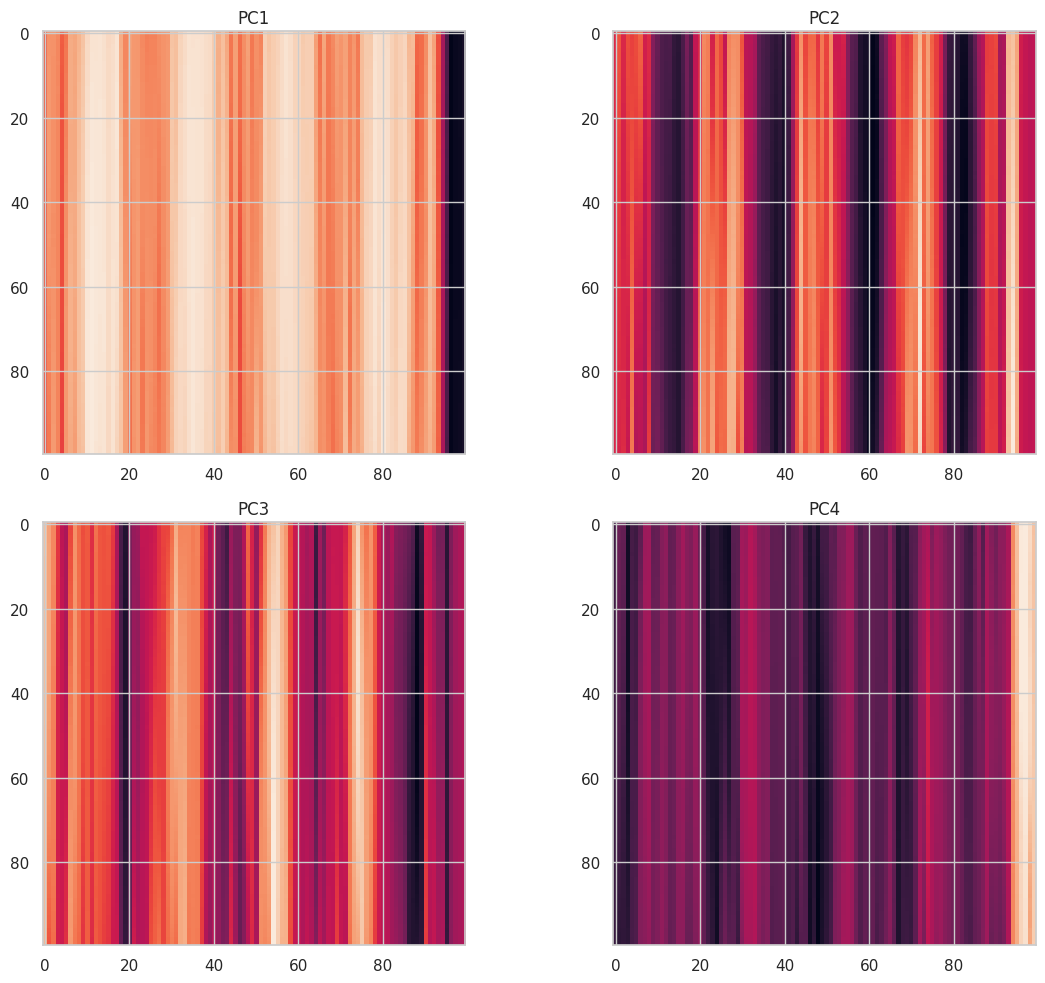

In [7]:
pca = pipeline.named_steps['pca']

num_plots = min(len(pca.components_), 4)
num_cols = 2
num_rows = (num_plots + 1)//num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6*num_cols, 5*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        pc = np.moveaxis(pc.reshape(-1, 100, 100), 0, -1)
        # pc = (pc - np.min(pc, axis=(0, 1))) / (np.max(pc, axis=(0, 1)) - np.min(pc, axis=(0, 1)))
        axes[row, col].imshow(pc[:,:,0])
        axes[row, col].set_title('PC' + str(idx + 1))
fig.tight_layout()
plt.show()

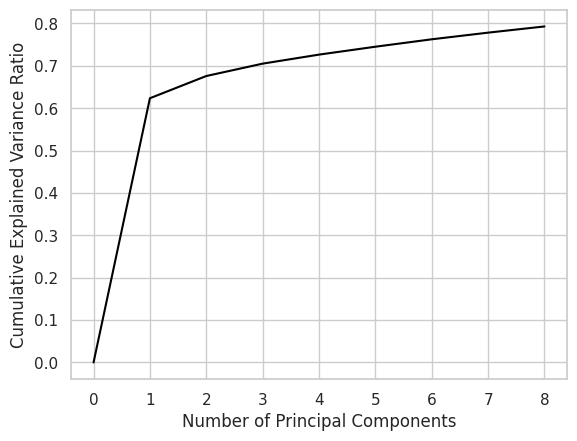

In [8]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [9]:
# X_pca = pipeline.named_steps['wavelet_transformer'].transform(X)
# X_pca = pipeline.named_steps['scaler'].transform(X_pca)
# X_pca = pipeline.named_steps['pca'].transform(X_pca)

# markers = ['o', 'x']
# for i, marker in enumerate(markers):
#     plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities)[y == i])

# plt.legend()
# plt.colorbar()
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

# X_reduced = X_pca[:,:2]

# model = clone(pipeline.named_steps['svm'])

# model.fit(X_reduced, y)
# disp = DecisionBoundaryDisplay.from_estimator(
#     model, X_reduced, response_method="predict",
#     xlabel='PC1', ylabel='PC2',
#     alpha=0.5,
# )
# scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
# disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
# plt.show()

In [10]:
cvd_directory_list = ['2024-03-06-Jens', '2024-03-15-Wert', '2024-03-15-Fisch']
X_cvd, y_cvd, groups_cvd, severities_cvd, _ = build_dataset(cvd_directory_list)
X_cvd = zero_pad(X_cvd, max_len)

In [11]:
y_pred_cvd = pipeline.predict(X_cvd)

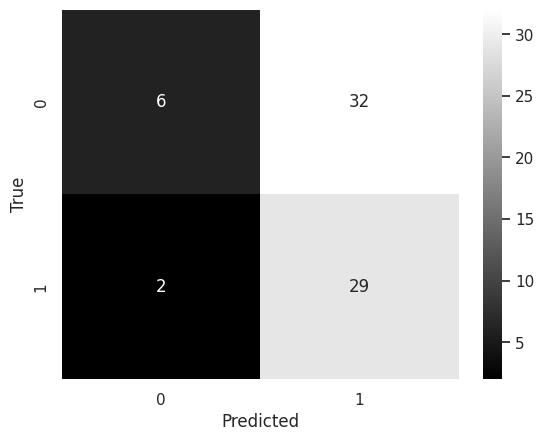

In [12]:
conf_matrix = confusion_matrix(y_cvd, y_pred_cvd)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

No CVD No Sim
a: 0.39, b: 0.94


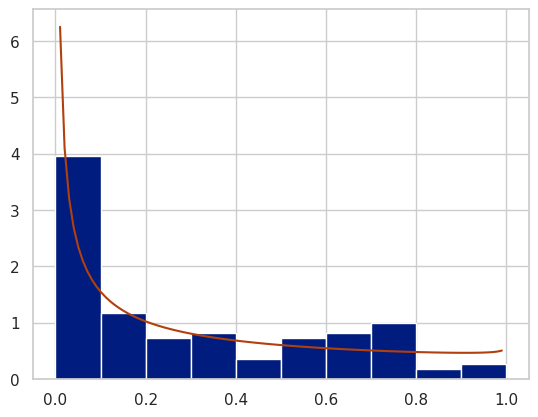

No CVD Sim
a: 2.53, b: 0.93


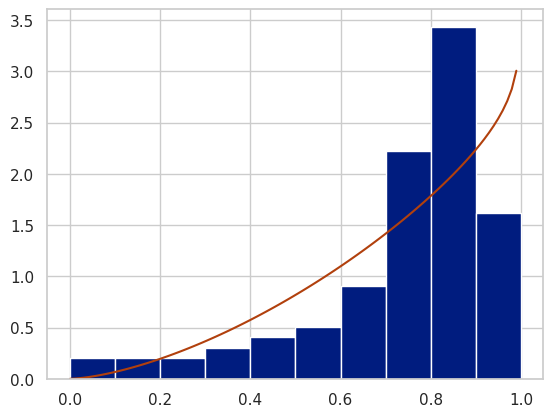

CVD Sim


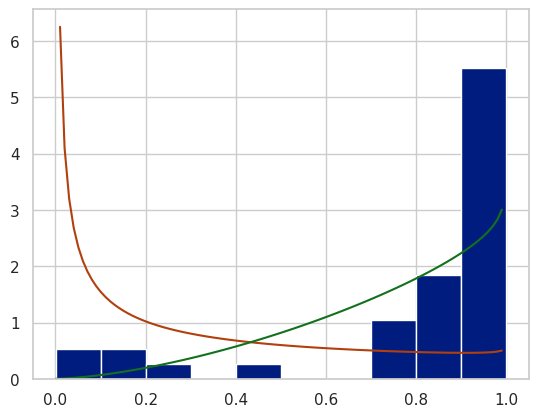

In [32]:
no_cvd_no_sim = y_pred_proba[y_test == 0][:, 1]
no_cvd_sim = y_pred_proba[y_test == 1][:, 1]

no_cvd_no_sim = np.concatenate((no_cvd_no_sim, np.linspace(0, 1, 20)))
no_cvd_sim = np.concatenate((no_cvd_sim, np.linspace(0, 1, 20)))

mu_no_cvd = np.mean(no_cvd_no_sim)
sigma_no_cvd = np.std(no_cvd_no_sim)
a_no_cvd = mu_no_cvd*(mu_no_cvd*(1-mu_no_cvd)/sigma_no_cvd**2 - 1)
b_no_cvd = (1-mu_no_cvd)*(mu_no_cvd*(1-mu_no_cvd)/sigma_no_cvd**2 - 1)

mu_cvd = np.mean(no_cvd_sim)
sigma_cvd = np.std(no_cvd_sim)
a_cvd = mu_cvd*(mu_cvd*(1-mu_cvd)/sigma_cvd**2 - 1)
b_cvd = (1-mu_cvd)*(mu_cvd*(1-mu_cvd)/sigma_cvd**2 - 1)

# regularization_strength = 0.5
# a_no_cvd += regularization_strength * (2 - a_no_cvd)
# b_no_cvd += regularization_strength * (2 - b_no_cvd)
# a_cvd += regularization_strength * (1 - a_cvd)
# b_cvd += regularization_strength * (1 - b_cvd)

print('No CVD No Sim')
print(f'a: {a_no_cvd:.2f}, b: {b_no_cvd:.2f}')
plt.hist(no_cvd_no_sim, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_no_cvd, b_no_cvd))
plt.show()

print('No CVD Sim')
print(f'a: {a_cvd:.2f}, b: {b_cvd:.2f}')
plt.hist(no_cvd_sim, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_cvd, b_cvd))
plt.show()

print('CVD Sim')
plt.hist(y_pred_proba_cvd[y_cvd == 0][:, 1], density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_no_cvd, b_no_cvd))
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_cvd, b_cvd))
plt.show()

Subject: Sofia, Accuracy: 50.00%
Log Likelihood No CVD: 0.6372869698791583
Log Likelihood CVD: -13.210014181053507
No CVD


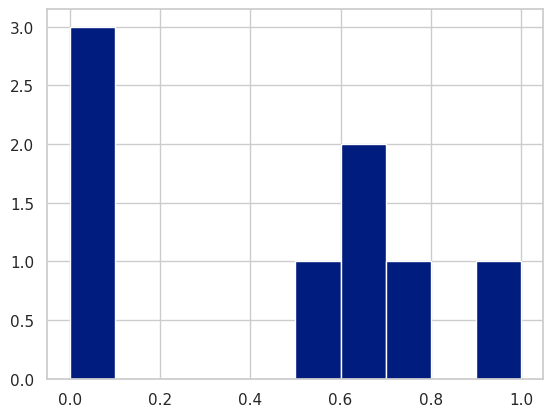

Subject: Badewanne, Accuracy: 42.86%
Log Likelihood No CVD: 5.983715671827218
Log Likelihood CVD: -25.11662378269121
No CVD


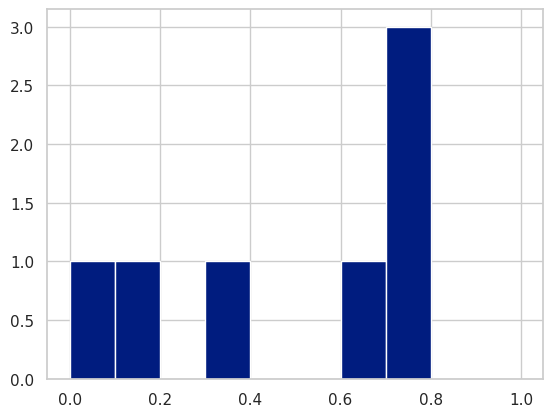

Subject: Happy, Accuracy: 83.33%
Log Likelihood No CVD: 33.12181130682414
Log Likelihood CVD: -92.35275679601551
No CVD


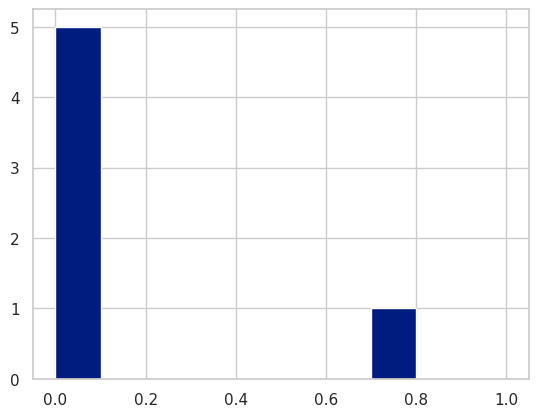

Subject: Schwein, Accuracy: 71.43%
Log Likelihood No CVD: 1.3295422900414064
Log Likelihood CVD: -13.872850502464964
No CVD


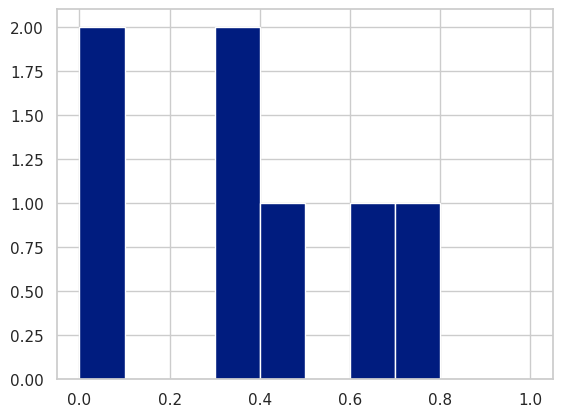

Subject: Tomate, Accuracy: 77.78%
Log Likelihood No CVD: -1.308250988093529
Log Likelihood CVD: -10.424504681755494
No CVD


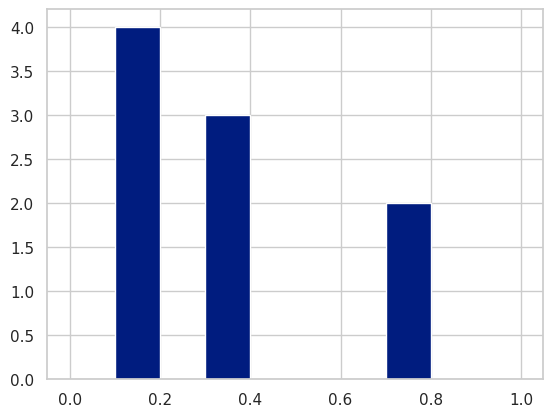

Subject: Schroedi, Accuracy: 100.00%
Log Likelihood No CVD: 26.738480177746236
Log Likelihood CVD: -75.07544823215385
No CVD


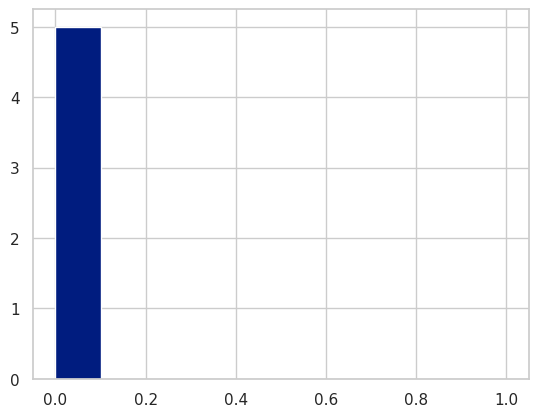

Subject: Daddy, Accuracy: 77.78%
Log Likelihood No CVD: 4.624099056912159
Log Likelihood CVD: -25.495970853744748
No CVD


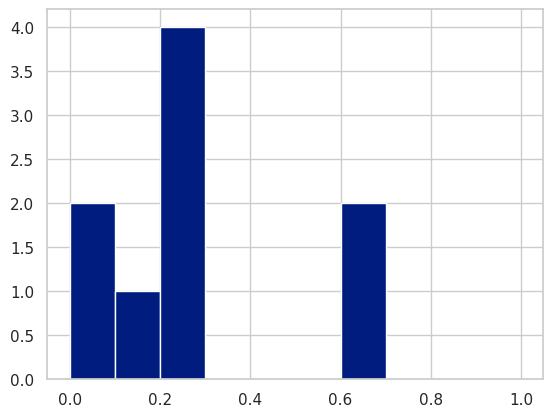

Subject: Marius, Accuracy: 100.00%
Log Likelihood No CVD: -0.08077665642325271
Log Likelihood CVD: -10.776180018750022
No CVD


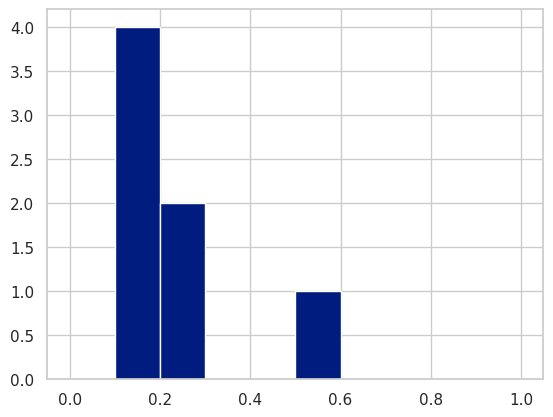

Subject: Maracuja, Accuracy: 83.33%
Log Likelihood No CVD: -3.230143413946767
Log Likelihood CVD: -0.6449344571976617
CVD


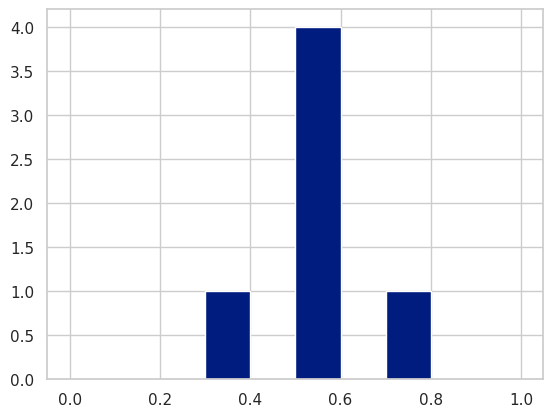

Subject: Lillifee, Accuracy: 100.00%
Log Likelihood No CVD: 18.661793438975238
Log Likelihood CVD: -54.866829953896215
No CVD


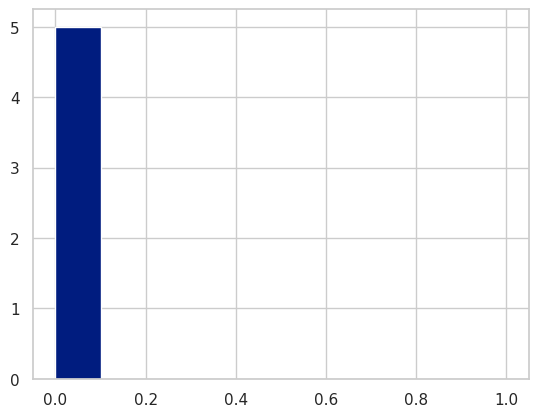

Subject: Gurke, Accuracy: 90.91%
Log Likelihood No CVD: 20.133967834702574
Log Likelihood CVD: -67.94384418011842
No CVD


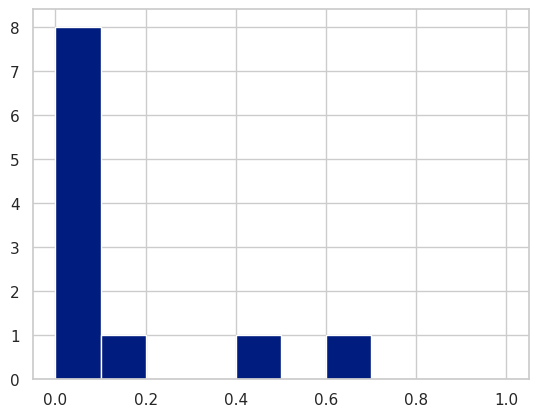

Subject: Geri, Accuracy: 100.00%
Log Likelihood No CVD: 36.02197545018837
Log Likelihood CVD: -108.07065026739991
No CVD


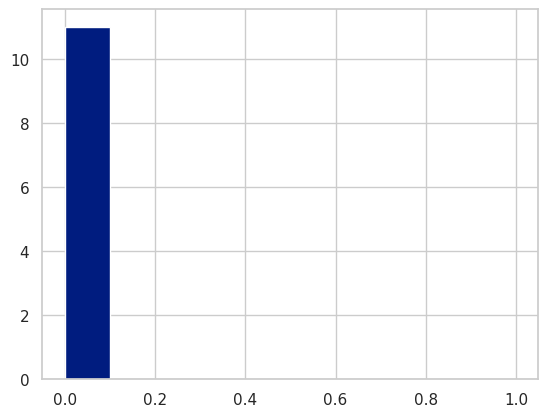

Subject: Wert, Accuracy: 25.00%
Log Likelihood No CVD: -5.659449800358561
Log Likelihood CVD: 1.8378184507105697
CVD


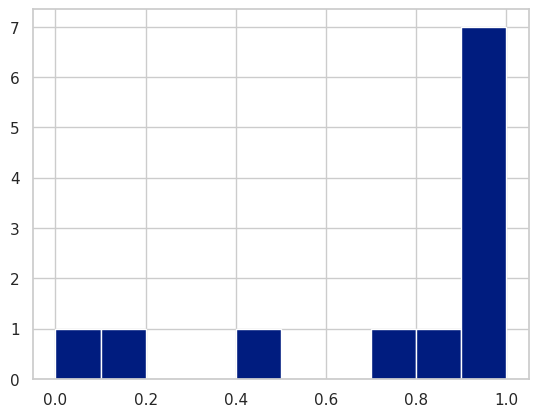

Subject: Jens, Accuracy: 18.75%
Log Likelihood No CVD: -5.329480061240312
Log Likelihood CVD: -2.040897690115149
CVD


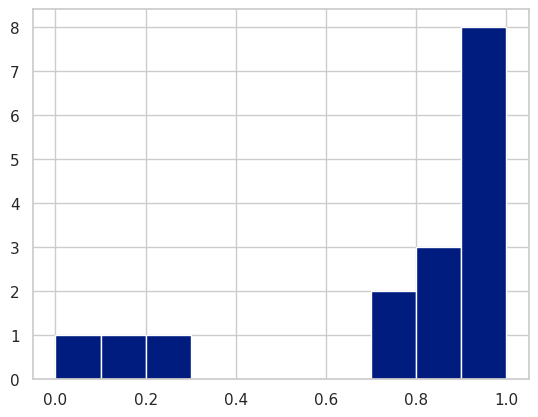

Subject: Fisch, Accuracy: 0.00%
Log Likelihood No CVD: -7.608543797575
Log Likelihood CVD: 8.05935414263856
CVD


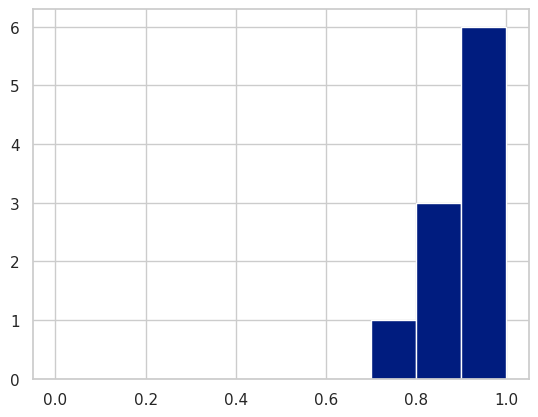

In [33]:
for group in set(groups_test):
    y_group_pred = y_pred[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred_proba = y_pred_proba[np.logical_and(groups_test == group, y_test == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_no_cvd, b_no_cvd))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_cvd, b_cvd))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()

for group in set(groups_cvd):
    y_group_pred = y_pred_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    y_group_pred_proba = y_pred_proba_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_no_cvd, b_no_cvd))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_cvd, b_cvd))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()